In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from types import SimpleNamespace
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import xarray
import pandas as pd
from dataset.dataset import ImageDataset, SingleImageDataset
from dataset.normalization import MinMax, ZeroMinMax
from dataset.station_dataset import GroundstationDataset, GroundstationDataset2
from lightning.pytorch import Trainer
from lightning.pytorch.loggers import WandbLogger
from models.ConvResNet_Jiang import ConvResNet, ConvResNet_dropout, ConvResNet_batchnormMLP
from models.LightningModule import LitEstimator, LitEstimatorPoint
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from utils.plotting import prediction_error_plot
from cartopy.mpl.gridliner import (
    LongitudeFormatter,
    LatitudeFormatter,
    LongitudeLocator,
    LatitudeLocator,
)
plt.rcParams['text.usetex'] = False


In [3]:
def predictions_to_image(predictions, input_image, config, patch_size):

    y_hat = torch.cat([x[0] for x in predictions]).squeeze()
    y = torch.cat([x[1] for x in predictions]).squeeze()
    lat = torch.cat([x[2][:, 1] for x in predictions])
    lon = torch.cat([x[2][:, 2] for x in predictions])

    img_dim = (len(input_image.lon) - config.patch_size['x'] +1,
               len(input_image.lat) - config.patch_size['y'] +1,)
    
    y_hat = y_hat.reshape(img_dim)
    y = y.reshape(img_dim)
    lat = lat.reshape(img_dim)
    lon = lon.reshape(img_dim)

    y_hat = config.target_transform.inverse(y_hat, ["SIS"])
    y = config.target_transform.inverse(y, ["SIS"])
    lat = config.transform.inverse(lat, ["lat"])
    lon = config.transform.inverse(lon, ["lon"])

    output_image = xarray.DataArray(
        data=y_hat.T,
        # dims=('x','y'),
        coords={"lat": (('lat'), lat[0, :]),
                "lon": (('lon'), lon[:, 0]),},
        attrs=input_image.SIS.attrs,
    )

    output_image.lat.attrs = input_image.lat.attrs
    output_image.lon.attrs = input_image.lon.attrs
    return output_image, y, y_hat


def image_1d_to_2d(arr, dim, patch_size):
    return arr.reshape(
        dim[0] - patch_size["y"] + 1,
        dim[1] - patch_size["x"] + 1,
    )

def plot_comparison_image(output_image, ground_truth_image, extent=None, savefig = True):
    nm = ground_truth_image.name
    time = ground_truth_image.time.dt.strftime('%Y%m%d_%H%M').item()
    time_pretty = ground_truth_image.time.dt.strftime('%Y-%m-%d %H:%M').item()
    proj = ccrs.PlateCarree()
    # fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(12,6), subplot_kw={"projection": proj})
    fig = plt.figure(figsize=(12, 5))
    gs = fig.add_gridspec(
        2,
        4,
        width_ratios=(3, 3, 3, .2),
        height_ratios=(3,.125),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.1,
    )
    ax1 = fig.add_subplot(gs[0, 0], projection=proj)
    ax2 = fig.add_subplot(gs[0, 1], projection=proj, sharex=ax1, sharey=ax1)
    ax3 = fig.add_subplot(gs[0, 2], projection=proj, sharex=ax1, sharey=ax1)
    axc1 = fig.add_subplot(gs[1, :2], autoscale_on=False)
    axc2 = fig.add_subplot(gs[:, 3])
    
    ax_text = fig.add_subplot(gs[1,2])
    ax_text.axis('off')
    ax_text.annotate(time_pretty, 
                xycoords='axes fraction',
                xy=[.3, .5])


    
    output_image.plot.imshow(x='lon', y='lat', 
                             vmin=0, vmax=1100, 
                             ax=ax1, transform=proj, add_colorbar=False)
    ground_truth_image.plot.imshow(x='lon', y='lat', 
                                   vmin=0, vmax=1100, ax=ax2, 
                                   transform=proj, cbar_ax=axc1,
                                  cbar_kwargs={'orientation':'horizontal', 'shrink':0.6, 'aspect':40,'label':'SIS [W/m2]'})
    
    error = output_image - ground_truth_image.reindex_like(output_image, method="nearest")
    error.plot.imshow(ax=ax3, transform=proj, cbar_ax=axc2)
    ax1.set_title("DL")
    ax2.set_title("SARAH3")
    ax3.set_title("y_pred - y")
    
    gls = {}
    for i, ax in enumerate([ax1,ax2,ax3]):
        ax.coastlines()
        gl = ax.gridlines(draw_labels=True, linewidth=.3)
        gl.top_labels = False
        gl.right_labels = False
        if i>0:
            gl.left_labels = False
        

    
    if extent is not None:
        ax1.set_xlim([extent[0], extent[2]])
        ax1.set_ylim([extent[1], extent[3]])
    
    if savefig:
        
        if extent is not None:
            extent_str = '_'.join([str(x) for x in extent])
            fig.savefig(inference_fn  + f'{nm}_comparison_{time}_{extent_str}.png')
        else:
            pass
            fig.savefig(inference_fn + f'{nm}_comparison_{time}.png')

# Config

In [4]:
## Set Up Model

# ckpt_fn = "/scratch/snx3000/kschuurm/irradiance_estimation/train/SIS_point_estimation/vh232f2j/checkpoints/epoch=11-step=11928.ckpt"
ckpt_fn = "../train/SIS_point_estimation/wv1ykh5d/checkpoints/epoch=5-step=5964.ckpt"

inference_fn = ckpt_fn.split('checkpoints')[0] + 'inference/'
if not os.path.exists(inference_fn):
    os.mkdir(inference_fn)

config = {
    "batch_size": 2048,
    "patch_size": {
        "x": 15,
        "y": 15,
        "stride_x": 1,
        "stride_y": 1,
    },
    "x_vars": [
        "channel_1",
        "channel_2",
        "channel_3",
        "channel_4",
        "channel_5",
        "channel_6",
        "channel_7",
        "channel_8",
        "channel_9",
        "channel_10",
        "channel_11",
        "DEM",
    ],
    "y_vars": ["SIS"],
    "x_features": ["dayofyear", "lat", "lon", "SZA", "AZI"],
    "transform": ZeroMinMax(),
    "target_transform": ZeroMinMax(),
}
config = SimpleNamespace(**config)



# Trainer and Model

In [31]:
# estimator = LitEstimator()
trainer = Trainer(
    # profiler="simple",
    # num_sanity_val_steps=2,
    accelerator="cpu",
    devices=1,
    precision="32",
)

model = ConvResNet_batchnormMLP(
    num_attr=len(config.x_features),
    input_channels=len(config.x_vars),
    output_channels=len(config.y_vars),
)

estimator = LitEstimatorPoint.load_from_checkpoint(
    ckpt_fn,
    learning_rate=0.001,
    model=model,
    config=config,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Station dataset

In [44]:
test_datasets = [GroundstationDataset2('/home/kr/Documents/Solar_Power_Forecasting/03_ground_stations/DWD/DWD_SOLAR_01078.zarr', 
                                config.y_vars, config.x_vars, config.x_features, config.patch_size['x'], config.transform, config.target_transform)]

stations = ['DWD_SOLAR_01078']



torch.Size([57158, 1, 15, 15])


In [45]:
predictions_stations = [trainer.predict(estimator, DataLoader(ds, 2000, shuffle=False)) for ds in test_datasets]

predictions_stations = { nm: {'y_hat': torch.cat([p[0] for p in pred]),
                              'y': torch.cat([p[1] for p in pred]),
                              'x': torch.cat([p[2] for p in pred]) } for nm, pred in zip(stations, predictions_stations)}

/home/kr/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 29/29 [01:01<00:00,  0.47it/s]


(tensor(0), tensor(15015))

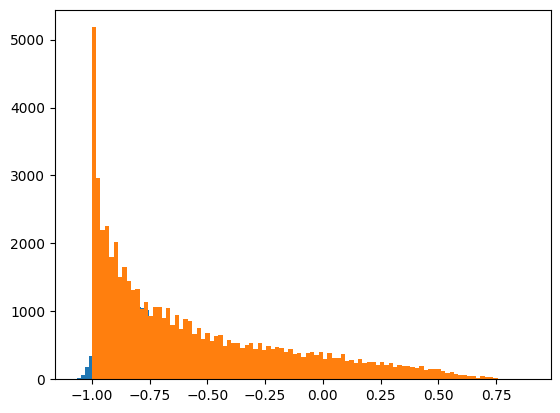

In [48]:
y_hat = predictions_stations['DWD_SOLAR_01078']['y_hat']
y = predictions_stations['DWD_SOLAR_01078']['y']
_  = plt.hist(y_hat.numpy(), bins=100)
_ = plt.hist(y.numpy(), bins=100)

y.isnan().sum(), y_hat.isnan().sum()

tensor([ 31.3453,  79.8537,  44.7276,  ...,   9.5361,  -5.8843, -20.2728])


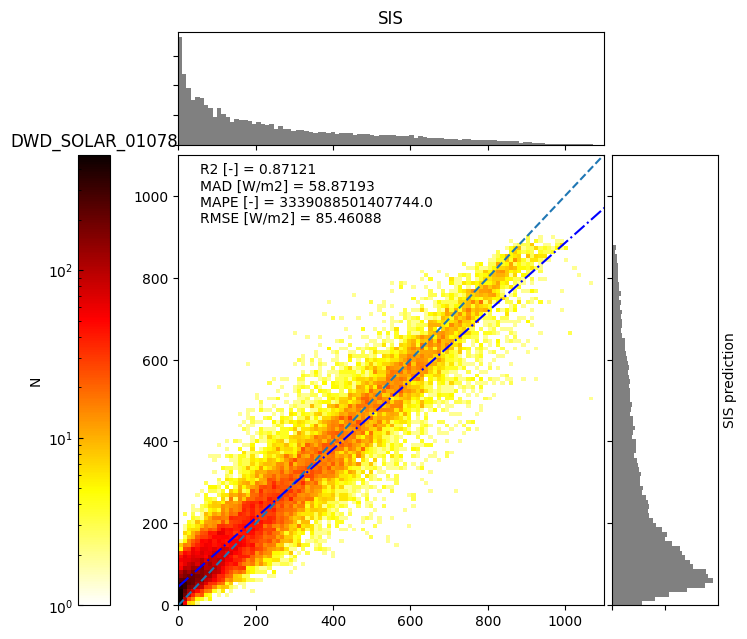

In [52]:
from torchmetrics import R2Score

r2score = R2Score()

def statistics_stations(predictions_stations, save = True):
    for key, val in predictions_stations.items():
        y_hat = config.transform.inverse(val['y_hat'].cpu(), ['SIS'])
        y = config.transform.inverse(val['y'].cpu(), ['SIS'])
        error = y_hat - y
        nan = ~error.isnan()
        error = error[nan]
        y=y[nan]
        y_hat=y_hat[nan]
        # error = config.transform.inverse(error.squeeze().cpu(), ["SIS"])
        print(error)
        mean = torch.nanmean(error).item()
        std = torch.std(error).item()
        median = torch.nanmedian(error).item()
        rmse = torch.sqrt(torch.nanmean(error**2)).item()
        R2 = r2score(y_hat.flatten(), y.flatten()).item()
        # print(f"{key}: \t mean err: {round(mean)}\t std err: {round(std)} \t median err: {round(median)} \t R2score: {round(R2, 3)} \t RMSE: {round(rmse,3)}")
        fig = prediction_error_plot(y, y_hat, title=key)
        fig.savefig(inference_fn + f'prediction_error_plot_{key}.png')
        
        
statistics_stations(predictions_stations, False)

# Full image comparison

In [13]:
imageDataset = ImageDataset(
    x_vars=config.x_vars,
    y_vars=config.y_vars,
    x_features=config.x_features,
    patch_size=config.patch_size,
    transform=config.transform,
    target_transform=config.target_transform,
    random_sample=None,
    batch_in_time=None,
    dtype=torch.float32,
)

dts = imageDataset.images

In [22]:
a = pd.DatetimeIndex([dt[0] for dt in dts])
a = a[a.year == 2016]

In [ ]:
from dataset.dataset import valid_test_split, pickle_write, pickle_read

_, subset = valid_test_split(a)
subsubset = np.random.choice(subset, 200, replace=False)
subsubset

In [ ]:
from dataset.dataset import valid_test_split, pickle_write, pickle_read
for dt in tqdm(subsubset[:]):
    try:
        dataset = imageDataset.load_singleImageDataset_generator(dt=[dt]).result()
        

        time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
        fn = inference_fn + f'predictions/predictions_{time_str}.pkl'
        os.makedirs(os.path.dirname(fn), exist_ok=True)
        if not os.path.exists(fn):
            dataloader = DataLoader(dataset, batch_size=1000, num_workers=3)
            predictions = trainer.predict(estimator, dataloader)
            pickle_write(predictions, fn)
        else:
            predictions = pickle_read(fn)

        output_image, y, y_hat = predictions_to_image(
            predictions, dataset.sarah, config, config.patch_size
        )
        plot_comparison_image(output_image, dataset.sarah.isel(time=0).SIS)#, extent=[5, 40, 15,50])

        fig = prediction_error_plot(y.flatten(), y_hat.flatten())
        time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
        fig.savefig(inference_fn + f'prediction_error_plot_{time_str}.png')
    except Exception as e:
        print(dt)
        print(e)
        

In [13]:
dataset = imageDataset.load_singleImageDataset_generator(dt=dts[4200]).result()

In [14]:
dataloader = DataLoader(dataset, batch_size=1000, num_workers=3)
predictions = trainer.predict(estimator, dataloader)

/scratch/snx3000/kschuurm/lightning2/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/snx3000/kschuurm/lightning2/lib/python3.9/s ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [17]:
output_image, y, y_hat = predictions_to_image(
    predictions, dataset.sarah, config, config.patch_size
)

{'R2 [-]': 0.6414765370077473, 'MAD [W/m2]': 37.51197, 'MAPE [-]': 3.0853662e+16}


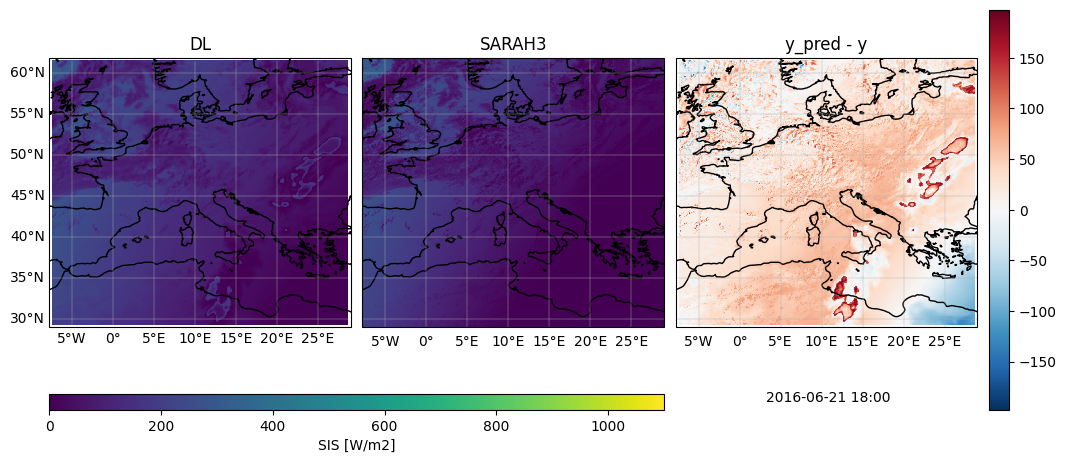

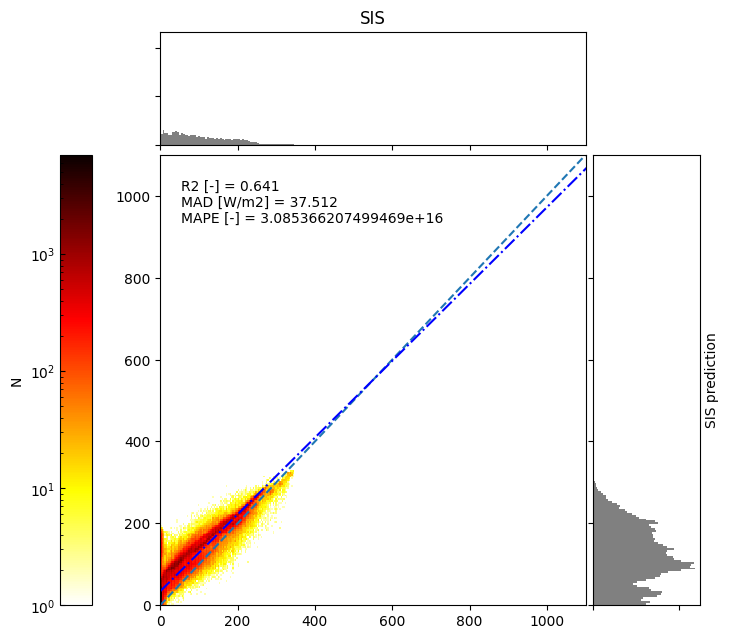

In [18]:
plot_comparison_image(output_image, dataset.sarah.isel(time=0).SIS)#, extent=[5, 40, 15,50])

fig = prediction_error_plot(y.flatten(), y_hat.flatten())
time_str = dataset.sarah.time.dt.strftime('%Y%m%d_%H%M').item()
fig.savefig(inference_fn + f'prediction_error_plot_{time_str}.png')